In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding-2/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding-2/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding-2/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding-2/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding-2/train_labels.csv
/kaggle/input/stanford-rna-3d-folding-2/train_sequences.csv
/kaggle/input/stanford-rna-3d-folding-2/MSA/6XRQ.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/1NJN.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/3D2G.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/5HR6.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/7KD1.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/8FTI.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/3G6E.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/7QR3.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/5V17.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/5NWQ.MSA.fasta
/kaggle/input/stanford-rna-3d-folding-2/MSA/8

In [2]:
# ============================================================
# Stanford RNA 3D Folding Part 2 — Complete EDA
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "/kaggle/input/stanford-rna-3d-folding-2"

# ============================================================
#  Basic File Structure
# ============================================================

print("Top Level:")
print(os.listdir("/kaggle/input"))

print("\nCompetition Folder:")
print(os.listdir(DATA_PATH))

print("\nNumber of CIF files:")
print(len(os.listdir(f"{DATA_PATH}/PDB_RNA")))


Top Level:
['stanford-rna-3d-folding-2']

Competition Folder:
['MSA', 'sample_submission.csv', 'validation_sequences.csv', 'test_sequences.csv', 'validation_labels.csv', 'extra', 'train_labels.csv', 'train_sequences.csv', 'PDB_RNA']

Number of CIF files:
9566


In [3]:
# ============================================================
# Load Data
# ============================================================

train_seq = pd.read_csv(f"{DATA_PATH}/train_sequences.csv")
val_seq   = pd.read_csv(f"{DATA_PATH}/validation_sequences.csv")
test_seq  = pd.read_csv(f"{DATA_PATH}/test_sequences.csv")

train_labels = pd.read_csv(
    f"{DATA_PATH}/train_labels.csv",
    low_memory=False
)

print("Train sequences:", train_seq.shape)
print("Train labels:", train_labels.shape)

Train sequences: (5716, 8)
Train labels: (7794971, 8)


count      5716.000000
mean       1363.710812
std        2602.689011
min          10.000000
25%          43.000000
50%          94.500000
75%        2583.750000
max      125580.000000
Name: length, dtype: float64


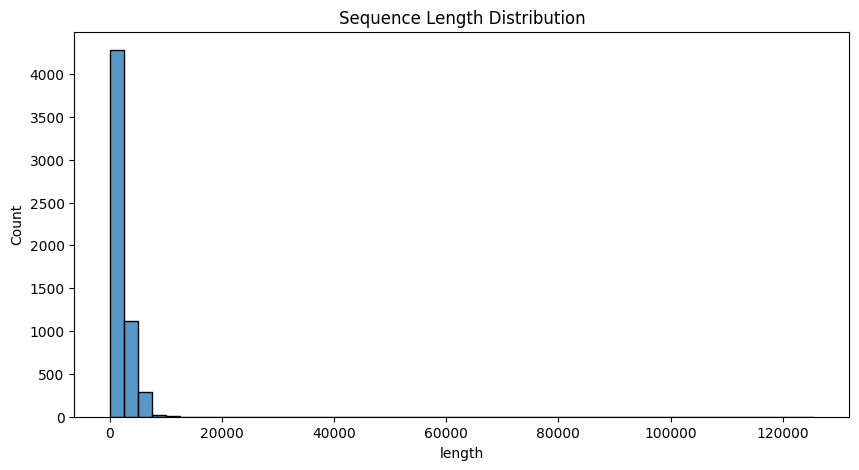

<300 nt: 3570
<1000 nt: 3827
>5000 nt: 332
>10000 nt: 10
Train max length: 125580
Test max length: 4640


In [4]:
# ============================================================
# Sequence Length Analysis
# ============================================================

train_seq["length"] = train_seq["sequence"].apply(len)

print(train_seq["length"].describe())

plt.figure(figsize=(10,5))
sns.histplot(train_seq["length"], bins=50)
plt.title("Sequence Length Distribution")
plt.show()

print("<300 nt:", (train_seq["length"] < 300).sum())
print("<1000 nt:", (train_seq["length"] < 1000).sum())
print(">5000 nt:", (train_seq["length"] > 5000).sum())
print(">10000 nt:", (train_seq["length"] > 10000).sum())

print("Train max length:", train_seq["length"].max())
print("Test max length:", test_seq["sequence"].apply(len).max())


In [5]:
# ============================================================
# Label Structure Analysis
# ============================================================

print(train_labels.columns)

# Extract seq_id
train_labels["seq_id"] = train_labels["ID"].str.split("_").str[0]

# Residues per sequence
residue_counts = train_labels.groupby("seq_id").size()

print("Min residues:", residue_counts.min())
print("Median residues:", residue_counts.median())
print("Max residues:", residue_counts.max())
print("Total sequences:", residue_counts.shape[0])


Index(['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1', 'chain', 'copy'], dtype='object')
Min residues: 10
Median residues: 94.5
Max residues: 125580
Total sequences: 5716


Copy statistics:
count    5716.000000
mean        1.948565
std         8.385265
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       120.000000
Name: copy, dtype: float64


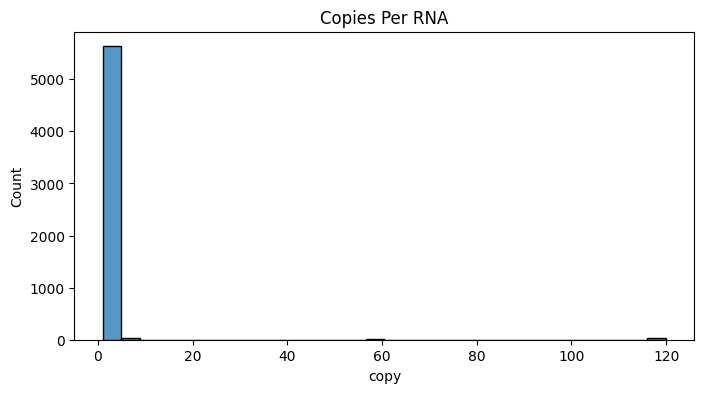

In [6]:
# ============================================================
# Copy / Assembly Duplication Analysis
# ============================================================

copies_per_seq = train_labels.groupby("seq_id")["copy"].nunique()

print("Copy statistics:")
print(copies_per_seq.describe())

plt.figure(figsize=(8,4))
sns.histplot(copies_per_seq, bins=30)
plt.title("Copies Per RNA")
plt.show()


In [7]:
# ============================================================
# CIF Coverage Check
# ============================================================

seq_ids = set(train_seq["target_id"].str.upper())

cif_ids = set([
    f.split(".")[0].upper()
    for f in os.listdir(f"{DATA_PATH}/PDB_RNA")
    if f.endswith(".cif")
])

print("Total sequence IDs:", len(seq_ids))
print("Total CIF IDs:", len(cif_ids))
print("Overlap:", len(seq_ids & cif_ids))
print("Missing in CIF:", len(seq_ids - cif_ids))
print("Extra in CIF:", len(cif_ids - seq_ids))


Total sequence IDs: 5716
Total CIF IDs: 9564
Overlap: 5716
Missing in CIF: 0
Extra in CIF: 3848


method
EM                  12626
X-ray               12608
NMR                  1004
Multiple methods       16
Other                   1
Name: count, dtype: int64
count    26255.000000
mean         5.079033
std          8.424271
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         79.000000
Name: assembly_rna_copies, dtype: float64


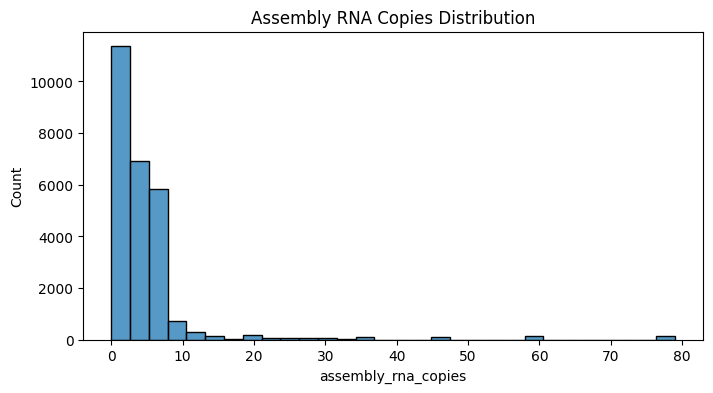

In [8]:
# ============================================================
# Metadata Analysis (Important)
# ============================================================

meta = pd.read_csv(f"{DATA_PATH}/extra/rna_metadata.csv")

print(meta["method"].value_counts())

print(meta["assembly_rna_copies"].describe())

plt.figure(figsize=(8,4))
sns.histplot(meta["assembly_rna_copies"], bins=30)
plt.title("Assembly RNA Copies Distribution")
plt.show()


In [9]:
# ============================================================
# Outlier Inspection
# ============================================================

very_long = train_seq[train_seq["length"] > 10000]
print("Sequences >10k nt:")
display(very_long[["target_id", "length"]].head())


Sequences >10k nt:


,target_id,length
1997,4V3P,125580
2370,5TGM,10473
2813,6I7O,11309
3072,6T83,11102
3104,6SV4,16804
